In [1]:
import json
import codecs
import os
import pandas as pd

<h2>0. Gathering the Data</h2>
<p>In this preliminary section, we will gather all of the cuneiform sign transliterations from the JSON files in our dataset. Then we will consolidate them into a data frame and match each sign value with its sign name</p>

(Do we need to discuss the basics of cuneiform transliteration or is it assumed that our audience is familiar with it?)

<h3>0.1: OGSL</h3>
<p>Now, we will load a map from sign value to sign name to use on the signs in our texts. The OGSL is... (website...)</p>

In [2]:
file_ogsl = codecs.open('ogsl-sl.json','r','utf-8')
ogsl = json.load(file_ogsl)
sign_index = ogsl['index']
sign_index

{'ʾu₄': 'A',
 'a': 'A',
 'aia₂': 'A',
 'aya₂': 'A',
 'barₓ': 'U',
 'buniŋₓ': 'A',
 'burₓ': '|4×TAB|',
 'dur₅': 'A',
 'duru₅': 'A',
 'e₄': 'A',
 'ea': 'A',
 'ebir₃': 'A',
 'emₓ': 'A',
 'epir₃': 'A',
 'eš₁₀': 'A',
 'ŋa₁₀': 'A',
 'ia₁₀': 'A',
 'id₅': 'A',
 'me₅': 'A',
 'mu₁₄': 'A',
 'sedₓ': '|MUŠ₃×DI|',
 'šegₓ': '|URU×ŠE|',
 'ṭur₅': 'A',
 'ya₁₀': 'A',
 'ai': '|A.A|',
 'aia': '|A.A|',
 'aya': '|A.A|',
 'aye': '|A.A|',
 'ayi': '|A.A|',
 'ayu': '|A.A|',
 'ayya': '|A.A|',
 'ayye': '|A.A|',
 'ayyi': '|A.A|',
 'ayyu': '|A.A|',
 'iya': '|A.A|',
 'iyi': '|A.A|',
 'iyu': '|A.A|',
 'iyya': '|A.A|',
 'iyyi': '|A.A|',
 'iyyu': '|A.A|',
 'yaₓ': '|UD.NI|',
 'ayayaₓ': '|A.A.A|',
 'a₄': '|A.AN|',
 'am₃': '|A.AN|',
 'še₇': '|A.AN|',
 'šeg₃': '|A.AN|',
 'šeŋ₃': '|A.AN|',
 'šemₓ': 'NE',
 'maštabaₓ': '|A.BI|',
 'a-ra₂': '|A.DU|',
 'tuše': '|A.DU|',
 'tuššuru': '|A.DU|',
 'eribₓ': '|SAL.UD|',
 'eru₄': '|A.EDIN|',
 'erua': '|A.EDIN|',
 'erum₄': '|A.EDIN|',
 'ummuₓ': '|EDIN.LAL.A|',
 'ummudₓ': '|A.U.EDIN.LAL|',

<h3>0.2: Collect the Text Signs</h3>
<p>The following code parses the JSON files of the ORACC texts and collects each sign transliteration. Since different signs have different types of reading, they are rendered differently in the JSON file and we must take care to recognize each sign reading type in the JSON file</p>
The types of signs and their representation in the JSON Files:
<ol>
    <li>Syllable - The reading of a sign as a syllable is rendered with a 'v' key</li>
    <li>Logogram - The reading of a sign as a logogram, i.e. one represents a word in itself or as part of a complex of signs that represents a single word is written in capital letters and with a 's' key</li>
    <li>Numerical - A sign representing a number (or personal name determinative) has an extra key called 'sexified'. This gives information on the number sign's wedge structure.</li>
</ol>

In addition, a modified sign can be any of the three types above, but written with a nonstandard paleography (e.g. a diagonal wedge is incised in the clay instead of a horizontal). These are the signs we want to examine. They have extra data given under the 'mods' key.

In [3]:
def process_signs(sign_data):
    sign_info = {}
    if 'v' in sign_data:
        sign_info['b'] = sign_data['v']
    if 's' in sign_data:
        sign_info['b'] = sign_data['s']
    if 'n' in sign_data:
        sign_info['b'] = sign_data.get('sexified',sign_data.get('form','noform?'))
    if 'mods' in sign_data:
        for m in sign_data['mods']:
            for d in m:
                sign_info[d] = m[d]
    if 'break' in sign_data:
        sign_info['break'] = sign_data['break']
    sign_info['sign_loc_id'] = sign_data.get('id','no-id')
    return sign_info    

In [4]:
types = set()
all_signs = []
for fname in os.listdir('corpusjson'):
    #if not fname == 'P224485.json':
    #    continue
    f = codecs.open('corpusjson/'+fname,'r','utf-8')
    j = json.load(f)
    #print(str(len(j['cdl'][0]['cdl'])))
    #print(fname)
    for a in j['cdl'][0]['cdl']:
        if a.get('type','') == 'discourse':
            for b in a['cdl']:
                if b.get('type','') == 'sentence':
                    line_label = ''                    
                    for c in b['cdl']:
                        if c.get('node','') == 'd': #This is the label for the line e.g. "o ii 3"
                            line_label = c.get('label','nolabel')
                        if c.get('node','') == 'l':
                            form = c['f']['form']
                            for sign_data in c['f']['gdl']:
                                if sign_data.get('det','') == 'semantic':
                                    for sd in sign_data['seq']:
                                        sign_info = process_signs(sd)
                                        sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                        all_signs.append(sign_info)
                                else:
                                    sign_info = process_signs(sign_data)
                                    sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                    all_signs.append(sign_info)
                        if c.get('node','') == 'c':
                            for d in c['cdl']:
                                if d.get('node','') == 'l':
                                    form = d['f']['form']
                                    for sign_data in d['f']['gdl']:
                                        if sign_data.get('det','') == 'semantic':
                                            for sd in sign_data['seq']:
                                                sign_info = process_signs(sd)
                                                sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                                all_signs.append(sign_info)
                                        else:
                                            sign_info = process_signs(sign_data)
                                            sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                            all_signs.append(sign_info)
                        #types.add(c.get('type','no type'))
                        
all_signs

[{'b': 'a',
  'break': 'damaged',
  'file': 'P224485.json',
  'form': 'a-bat',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.1.0'},
 {'b': 'bat',
  'file': 'P224485.json',
  'form': 'a-bat',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.1.1'},
 {'b': 'LUGAL',
  'file': 'P224485.json',
  'form': 'LUGAL',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.2.0'},
 {'b': 'a',
  'file': 'P224485.json',
  'form': 'a-na',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.3.0'},
 {'b': 'na',
  'f': 't',
  'file': 'P224485.json',
  'form': 'a-na',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.3.1'},
 {'b': '1(diš)',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.0'},
 {'b': 'aš',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.1'},
 {'b': 'šur',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.2'

Now, we form our Data Frame where each row contains information on every sign in the corpus. Further limitations on which signs are significant to our purposes will be made later, but for now we will eliminate all of the signs which are labelled as "missing," (i.e. reconstructed) because any information based on their paleography or orthography cannot be ascertained.

In [5]:
df = pd.DataFrame(all_signs)
df = df.fillna('')
df = df[(df['break'] != 'missing')]
df

,a,b,break,f,file,form,line_label,m,sign_loc_id
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1
5,,1(diš),,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.0
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1
7,,šur,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.2
8,,MAN,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.3
9,,PAB,damaged,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.4


<h3>1. Setting Up the Data for Clustering</h3>
<p>The general goal is to assign a vector to each text that reflects the usage of variant orthography and paleography.</p>
<ol>
    <li>Paleography - Any one set of wedges that we classify as a sign can be impressed on the clay in different ways. For example, a wedge can be missing or one can be added. Also, the tilt of a wedge can variable. These are the features we want to examine in order to see if one text prefers one sign writing or another.</li>
    <li>Orthography - Due to the homophony of the cuneiform writing system, one syllable can be written with many signs. For example, 'li' can be written with the LI-sign but also with the NI-sign, in which case it would be transliterated as li<sub>2</sub></li>
</ol>
<p>Other variables can be applied to a text as attributes in its vector. (What are these? We talked about things like Provenence, city information, scribe information. Also, if we apply different types of variables how can we use a clustering algorithm to treat these vector components as a different entity?).</p>
<p>This section therefore contains two subsections. One groups the diagnostic signs with or without modifications per text to. The other discovers the homophonous signs used throughout the corpus and groups different usages per text</p>

First of all, let's create more columns in the data frame to aid us
<ol>
<li>mods_str - Since the data contains three columns currently with information on variable paleography, it would help us to consolidate them into one column</li>
<li>str_part and num_part - In order to determine which signs share a syllabic value, it will be useful to separate the transliterated readings into their string components and numerical components. Once we do this, we can group rows with the same str_part and count up the different usages of homophonous signs</li>

In [6]:
df['sign_form'] = df['b'].apply(lambda x: sign_index.get(x.lower(),'?'))
df['mods_str'] = df['a'] + '.' + df['f'] + '.' + df['m']

import re
def get_num_part(s):
    try:
        n = re.findall(r'[₀₁₂₃₄₅₆₇₈₉]+',s)[0]
        n = n.replace('₀','0').replace('₁','1').replace('₂','2').replace('₃','3').replace('₄','4')
        n = n.replace('₅','5').replace('₆','6').replace('₇','7').replace('₈','8').replace('₉','9')
    except:
        n = 1
    return n
def get_str_part(s):
    try:
        n = re.findall(r'[a-zA-ZšŠṣṢṭṬʾ \(\)0-9]+',s)[0]
    except:
        n = s
    return n
        
df['str_part'] = df['b'].apply(lambda x: get_str_part(x))
df['num_part'] = df['b'].apply(lambda x: get_num_part(x))
df

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0,A,..,a,1
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1,BAD,..,bat,1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0,LUGAL,..,LUGAL,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1,NA,.t.,na,1
5,,1(diš),,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.0,DIŠ,..,1(diš),1
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1,AŠ,..,aš,1
7,,šur,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.2,SUR,..,šur,1
8,,MAN,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.3,|U.U|,..,MAN,1
9,,PAB,damaged,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.4,PAP,..,PAB,1


<h3>1.1: Collection of Modified Signs</h3>
<p>The Data Frame we have contains the entire collection of signs in the corpus. However, not every sign has variants in paleography (at least according to Parpola's data input). We only want to look at the signs which have these variants, which we will term diagnostic. In the data, they are the signs that include any type of modification</p>

In [7]:
df2 = df[~(df['f'] == '') | ~(df['a'] == '') | ~(df['m'] == '')]
mod_signs = sorted(list(df2['sign_form'].unique()))
mod_signs

['A',
 'AK',
 'AL',
 'ALEPH',
 'ANŠE',
 'APIN',
 'ARAD',
 'A₂',
 'BA',
 'BAD',
 'BAL',
 'BARA₂',
 'BI',
 'BU',
 'BUR',
 'DA',
 'DI',
 'DIB',
 'DIM',
 'DIN',
 'DU',
 'DUB',
 'DUN',
 'E',
 'E₂',
 'GABA',
 'GAD',
 'GAL',
 'GAR',
 'GI',
 'GIŠ',
 'HA@g',
 'HI',
 'HU',
 'IG',
 'IGI',
 'IL',
 'IN',
 'IR',
 'IŠ',
 'KA',
 'KAK',
 'KAL',
 'KAM₂',
 'KA₂',
 'KI',
 'KIN',
 'KU',
 'KUL',
 'KUN',
 'KUR',
 'LA',
 'LAGAB',
 'LI',
 'LIL',
 'LIŠ',
 'LU',
 'LUGAL',
 'LUH',
 'LU₂',
 'MA',
 'MA@g',
 'MAR',
 'MU',
 'MURUB₄',
 'MUŠ',
 'NA',
 'NAGAR',
 'NAM',
 'NA₂',
 'NE@s',
 'NI',
 'NU',
 'NUN',
 'PAP',
 'RA',
 'RI',
 'RU',
 'SA',
 'SAG',
 'SAR',
 'SIG',
 'SIG₄',
 'SILA₃',
 'SU',
 'SUM',
 'TA',
 'TAG',
 'TAR',
 'TE',
 'TI',
 'TU',
 'TUG₂',
 'TUK',
 'UB',
 'UM',
 'UR',
 'URI',
 'URU',
 'URUDA',
 'U₂',
 'ZAG',
 'ZI',
 'ZIG',
 'ZU',
 '|A.LAGAB×HAL|',
 '|AB×HA|',
 '|AŠ@z&AŠ@z&AŠ@z&AŠ@z|',
 '|EZEN×BAD|',
 '|GA₂×NUN&NUN|',
 '|GI%GI|',
 '|GUD×KUR|',
 '|HI×AŠ₂|',
 '|IGI.DIB|',
 '|KA×A|',
 '|LAGAB×SUM|',
 '|ME.U.U.U|

We now limit our Data Frame to include ONLY these diagnostic signs.

In [8]:
df_modsigns = df[df['sign_form'].isin(mod_signs)]
#remove damaged signs too
df_modsigns = df_modsigns[df_modsigns['break'] != 'damaged']
df_modsigns

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1,BAD,..,bat,1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0,LUGAL,..,LUGAL,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1,NA,.t.,na,1
11,,mu,,,P224485.json,šul-mu,o 1,,P224485.2.5.1,MU,..,mu,1
14,,ši,,,P224485.json,ia-a-ši,o 1,,P224485.2.6.2,IGI,..,ši,1
16,,mu,,,P224485.json,šul-mu,o 2,,P224485.3.1.1,MU,..,mu,1
17,,a,,,P224485.json,a-na,o 2,,P224485.3.2.0,A,..,a,1
18,,na,,t,P224485.json,a-na,o 2,,P224485.3.2.1,NA,.t.,na,1
19,,KUR,,,P224485.json,KUR-aš-šur{KI},o 2,,P224485.3.3.0,KUR,..,KUR,1


<h3>1.2: Collection of Homophonous Signs</h3>
<p>We now limit the original data frame in different way based on orthography. First we need to figure out which syllabic readings have multiple signs that can render them.</p>

In [9]:
df2 = pd.DataFrame(df.groupby(['str_part'])['num_part'].agg('nunique'))
ortho_list = list(df2[df2[('num_part')] > 1].index)
ortho_list

['A',
 'BAD',
 'DU',
 'DUG',
 'GIN',
 'I',
 'KA',
 'KAM',
 'KU',
 'KUR',
 'KUŠ',
 'LU',
 'MA',
 'NA',
 'NIGIR',
 'SIG',
 'TUR',
 'U',
 'UŠ',
 'ZU',
 'a',
 'ar',
 'aš',
 'be',
 'bil',
 'da',
 'daq',
 'du',
 'gir',
 'gur',
 'i',
 'ia',
 'il',
 'in',
 'kal',
 'lah',
 'li',
 'me',
 'mi',
 'pil',
 'qi',
 'rig',
 'tu',
 'u',
 'ur',
 'ša',
 'šu',
 'šum',
 'ṭe',
 'ṭi']

We need to eliminate capital letter entries because indices on logograms indicate different words and are not relevant here.

In [10]:
ortho_list = [h for h in ortho_list if len(re.findall(r'[A-Z]',h)) == 0]
ortho_list

['a',
 'ar',
 'aš',
 'be',
 'bil',
 'da',
 'daq',
 'du',
 'gir',
 'gur',
 'i',
 'ia',
 'il',
 'in',
 'kal',
 'lah',
 'li',
 'me',
 'mi',
 'pil',
 'qi',
 'rig',
 'tu',
 'u',
 'ur',
 'ša',
 'šu',
 'šum',
 'ṭe',
 'ṭi']

Limit the dataframe to only these signs

In [11]:
df_ortho_signs = df[df['str_part'].isin(ortho_list)]
df_ortho_signs

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0,A,..,a,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1,AŠ,..,aš,1
12,,ia,,,P224485.json,ia-a-ši,o 1,,P224485.2.6.0,|I.A|,..,ia,1
13,,a,damaged,,P224485.json,ia-a-ši,o 1,,P224485.2.6.1,A,..,a,1
17,,a,,,P224485.json,a-na,o 2,,P224485.3.2.0,A,..,a,1
20,,aš,,,P224485.json,KUR-aš-šur{KI},o 2,,P224485.3.3.1,AŠ,..,aš,1
28,,ša,damaged,,P224485.json,ša,o 3,,P224485.4.1.0,ŠA,..,ša,1
34,,a,,,P224485.json,ma-a,o 3,,P224485.4.3.1,A,..,a,1
45,,me,,,P224485.json,{1}me-ta-a,o 3,,P224485.4.6.1,ME,..,me,1


<h3>2. Mixed vs. Complementary Distribution</h3>
<p>One of the goals of this project is to determine a preference for sign usage in one subgroup of the corpus versus another. To that end there is one more factor that needs to be discussed, namely the usage of these paleographic or orthographic variants within context. If the usage of these variants are context-dependent, meaning that one form or syllable is used in one context and another form or syllable in another context, it does not tell us much about the preferential usage of the signs. This is known as a complementary distribution. For example, if a scribe uses <i>li<sub>2</sub></i> only in the form of the word be-li<sub>2</sub> and the <i>li</i> sign in all other contexts, the choice of sign usage is not determined by the scribe's preference rather on scribal convention. This convention would thus be utilized by every scribe of this corpus and not help us to detect subgroups among these texts where scribes differ.</p>
<p>On the other hand, if sign form or syllable variants appear within the same contexts, it gives us the information we want on scribal writing preference or tendencies. For example, <i>ia</i> and <i>ia<sub>2</sub></i> both appear in forms of the word bēliya, meaning that a scribe had an option of orthography and incised one or the other. (NTS: I'm avoiding the term "choose" here because it is a very loaded term with implications that may be misleading here). The question then becomes whether certain texts group together based on their tendencies to use one variant within a mixed distribution versus another variant.</p>
<p>(paragraph about this dichotomy on the paleographic side of things. Mention TA vs. TA@v)</p>
<p>(closing paragraph summarizing the issue)</p>

<b>2.1 Paleographic Variant Distribution</b>

Now let's try to apply a quantitative method to figure out the level of mixed distribution which paleographic variants bear within word forms. The steps here are:
<ol>
    <li>Select only the particular sign forms and modifications that appear a sufficient number of times within the same forms</li>
    <li>Count the number of times these sign forms and modiciations occur in each text</li>
    <li>Create a text matrix which contains the appropriate distribution for the modifications within each sign form, adding 1 to each cell to avoid divide by zero issues</li>
</ol>

In [12]:
df_mods_agg = pd.DataFrame(df_modsigns.groupby(['sign_form','form','mods_str'])['a'].agg('count')).reset_index()
df_mods_agg.columns = ['sign_form','form','mods_str','count']
#first let's remove where total instances are less than a certain arbitrary value, say 5
df_mods_agg = df_mods_agg[df_mods_agg['count'] >= 5]
#NOW find and only keep the rows where sign_form and form are duplicates
df_mods_agg['is_dup'] = df_mods_agg.duplicated(['sign_form','form'],False)
df_mods_agg = df_mods_agg[df_mods_agg['is_dup'] == True]
df_mods_agg

,sign_form,form,mods_str,count,is_dup
1258,DA,u₂-da,..,7,True
1259,DA,u₂-da,.d.,6,True
1294,DI,DI-mu,..,103,True
1295,DI,DI-mu,.d.,35,True
1300,DI,a-di,..,18,True
1301,DI,a-di,.d.,8,True
2376,IG,iq-ṭi₂-bi-a,..,10,True
2377,IG,iq-ṭi₂-bi-a,.d.,5,True
2670,IŠ,iš-pur-an-ni,..,46,True
2672,IŠ,iš-pur-an-ni,.t.,6,True


In [13]:
df_select_signmods = df_mods_agg[['sign_form','mods_str']].drop_duplicates()
df_select_signmods['combined'] = df_select_signmods['sign_form'] + ':' + df_select_signmods['mods_str']
df_select_signmods

,sign_form,mods_str,combined
1258,DA,..,DA:..
1259,DA,.d.,DA:.d.
1294,DI,..,DI:..
1295,DI,.d.,DI:.d.
2376,IG,..,IG:..
2377,IG,.d.,IG:.d.
2670,IŠ,..,IŠ:..
2672,IŠ,.t.,IŠ:.t.
3862,LUGAL,..,LUGAL:..
3863,LUGAL,.d.,LUGAL:.d.


Create a list of the selected signs to limit the main paleography dataframe to only those sign forms

In [14]:
select_signs = list(df_mods_agg['sign_form'].unique())
select_signs

['DA',
 'DI',
 'IG',
 'IŠ',
 'LUGAL',
 'LU₂',
 'MA',
 'NA',
 'SU',
 'SUM',
 'TA',
 'U₂',
 '|EZEN×BAD|',
 '|GA₂×NUN&NUN|',
 '|ME.U.U.U|',
 '|PIRIG×UD|',
 'ŠA',
 'ŠA₃',
 'ŠIM']

In [15]:
df_file_select_signs = df_modsigns[df_modsigns['sign_form'].isin(select_signs)]
df_file_select_signs = pd.DataFrame(df_file_select_signs.groupby(['file','sign_form','mods_str'])['a'].agg('count')).reset_index()
df_file_select_signs['combined'] = df_file_select_signs['sign_form'] + ':' + df_file_select_signs['mods_str']
df_file_select_signs

,file,sign_form,mods_str,a,combined
0,P224485.json,DA,..,1,DA:..
1,P224485.json,DI,..,2,DI:..
2,P224485.json,DI,.d.,1,DI:.d.
3,P224485.json,IG,..,1,IG:..
4,P224485.json,LUGAL,..,7,LUGAL:..
5,P224485.json,LU₂,v..,15,LU₂:v..
6,P224485.json,MA,..,29,MA:..
7,P224485.json,MA,.d.,1,MA:.d.
8,P224485.json,NA,..,10,NA:..
9,P224485.json,NA,.t.,9,NA:.t.


Create the text matrix according to step 3 above

In [16]:
d_file_select_signs = {}
file_names = df_modsigns['file'].unique()
for f in file_names:
    d = {}
    e = {}
    for i, row in df_select_signmods.iterrows():
        try:
            n = int(df_file_select_signs[(df_file_select_signs['file'] == f) & (df_file_select_signs['combined'] == row['combined'])]['a']) + 1
        except TypeError:
            n = 1
            
        d[row['combined']] = n
        if row['sign_form'] in e:
            e[row['sign_form']] += n
        else:
            e[row['sign_form']] = n
        
    #d_select_signs[f] = [d['ia'] / ia_tot,d['ia₂'] / ia_tot,d['li'] / li_tot,d['li₂'] / li_tot,d['ša'] / sa_tot, d['ša₂'] / sa_tot,d['šu'] / su_tot,d['šu₂'] / su_tot]
    d_file_select_signs[f] = []
    for i,row in df_select_signmods.iterrows():
        d_file_select_signs[f].append(d[row['combined']] / e[row['sign_form']])
df_file_select_signs_c = pd.DataFrame(d_file_select_signs).transpose()
df_file_select_signs_c.columns = list(df_select_signmods['combined'])
df_file_select_signs_c

,DA:..,DA:.d.,DI:..,DI:.d.,IG:..,IG:.d.,IŠ:..,IŠ:.t.,LUGAL:..,LUGAL:.d.,...,ŠA:.tm.,ŠA:.tym.,ŠA:.y.,ŠA:.yd.,ŠA:.ydm.,ŠA:.ym.,ŠA₃:..,ŠA₃:.p.,ŠIM:..,ŠIM:.t.
P224485.json,0.666667,0.333333,0.600000,0.400000,0.666667,0.333333,0.500000,0.500000,0.727273,0.090909,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.833333,0.166667,0.500000,0.500000
P313416.json,0.500000,0.500000,0.666667,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.166667,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.666667,0.333333,0.500000,0.500000
P313417.json,0.750000,0.250000,0.714286,0.285714,0.500000,0.500000,0.500000,0.500000,0.625000,0.187500,...,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.428571,0.571429,0.500000,0.500000
P313425.json,0.250000,0.750000,0.333333,0.666667,0.333333,0.666667,0.666667,0.333333,0.727273,0.090909,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.833333,0.166667,0.500000,0.500000
P313427.json,0.571429,0.428571,0.500000,0.500000,0.500000,0.500000,0.750000,0.250000,0.625000,0.125000,...,0.062500,0.062500,0.062500,0.062500,0.187500,0.062500,0.666667,0.333333,0.500000,0.500000
P313435.json,0.500000,0.500000,0.666667,0.333333,0.500000,0.500000,0.500000,0.500000,0.666667,0.111111,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.666667,0.333333,0.666667,0.333333
P313437.json,0.500000,0.500000,0.333333,0.666667,0.500000,0.500000,0.500000,0.500000,0.571429,0.142857,...,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.500000,0.500000,0.500000,0.500000
P313439.json,0.800000,0.200000,0.500000,0.500000,0.500000,0.500000,0.666667,0.333333,0.750000,0.083333,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.666667,0.333333,0.500000,0.500000
P313447.json,0.666667,0.333333,0.666667,0.333333,0.666667,0.333333,0.666667,0.333333,0.700000,0.100000,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.142857,0.750000,0.250000,0.500000,0.500000
P313458.json,0.500000,0.500000,0.800000,0.200000,0.500000,0.500000,0.500000,0.500000,0.571429,0.142857,...,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.666667,0.333333,0.500000,0.500000


<b>2.1.2. Clustering on Paleography Alone</b>

In [17]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters=14, max_iter=1000).fit(df_file_select_signs_c)

labels_paleo = {}

km1.labels_

for i in range(len(km1.labels_)):
    if km1.labels_[i] in labels_paleo:
        labels_paleo[km1.labels_[i]].append(file_names[i])
    else:
        labels_paleo[km1.labels_[i]] = [file_names[i]]
labels_paleo

#Sennacherib the Prince
sar = ['P334141.json','P334390.json']
#Nabu-pašir, governor of Harran
np = ['P334807.json','P334080.json']
#Nabu-deʾiq
nd = ['P334568.json','P334792.json']

def find_cluster(pnum,labels):
    for k in labels:
        if pnum in labels[k]:
            return str(k)
        
print('Sennacherib clusters are: ',find_cluster(sar[0],labels_paleo),' and ',find_cluster(sar[1],labels_paleo))
print('Nabu-pašir clusters are: ',find_cluster(np[0],labels_paleo),' and ',find_cluster(np[1],labels_paleo))
print('Nabu-deʾiq clusters are: ',find_cluster(nd[0],labels_paleo),' and ',find_cluster(nd[1],labels_paleo))

Sennacherib clusters are:  4  and  5
Nabu-pašir clusters are:  3  and  2
Nabu-deʾiq clusters are:  6  and  0


<b>2.2. Orthographic Variant Distribution</b>

In [18]:
df_ortho_signs['form_str_part'] = df_ortho_signs['form'].apply(lambda x: re.sub(r'[₁₂₃₄₅₆₇₈₉₀]','',x))
df_ortho_signs

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part,form_str_part
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0,A,..,a,1,a-bat
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1,a-na
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1,AŠ,..,aš,1,{1}aš-šur-MAN-PAB
12,,ia,,,P224485.json,ia-a-ši,o 1,,P224485.2.6.0,|I.A|,..,ia,1,ia-a-ši
13,,a,damaged,,P224485.json,ia-a-ši,o 1,,P224485.2.6.1,A,..,a,1,ia-a-ši
17,,a,,,P224485.json,a-na,o 2,,P224485.3.2.0,A,..,a,1,a-na
20,,aš,,,P224485.json,KUR-aš-šur{KI},o 2,,P224485.3.3.1,AŠ,..,aš,1,KUR-aš-šur{KI}
28,,ša,damaged,,P224485.json,ša,o 3,,P224485.4.1.0,ŠA,..,ša,1,ša
34,,a,,,P224485.json,ma-a,o 3,,P224485.4.3.1,A,..,a,1,ma-a
45,,me,,,P224485.json,{1}me-ta-a,o 3,,P224485.4.6.1,ME,..,me,1,{1}me-ta-a


In [19]:
df_syls_agg = pd.DataFrame(df_ortho_signs.groupby(['str_part','form_str_part','b'])['a'].agg('count')).reset_index()
df_syls_agg.columns = ['str_part','form_str_part','b','count']
#first let's remove where total instances are less than a certain arbitrary value, say 5
df_syls_agg = df_syls_agg[df_syls_agg['count'] >= 5]
#NOW find and only keep the rows where sign_form and form are duplicates
df_syls_agg['is_dup'] = df_syls_agg.duplicated(['str_part','form_str_part'],False)
df_syls_agg = df_syls_agg[df_syls_agg['is_dup'] == True]
df_syls_agg

,str_part,form_str_part,b,count,is_dup
1061,ia,EN-ia,ia,218,True
1062,ia,EN-ia,ia₂,52,True
1074,ia,be-li-ia,ia,43,True
1075,ia,be-li-ia,ia₂,33,True
1249,li,be-li,li,6,True
1250,li,be-li,li₂,135,True
2033,u,u,u,12,True
2035,u,u,u₃,74,True
2296,u,šu-u,u,15,True
2297,u,šu-u,u₂,22,True


In [20]:
df_select_bs = df_syls_agg[['str_part','b']].drop_duplicates()
#Don't need to create combined column here because b is sufficient
#df_select_signmods['combined'] = df_select_signmods['sign_form'] + ':' + df_select_signmods['mods_str']
df_select_bs

,str_part,b
1061,ia,ia
1062,ia,ia₂
1249,li,li
1250,li,li₂
2033,u,u
2035,u,u₃
2297,u,u₂
2429,ša,ša
2430,ša,ša₂
2828,šu,šu


In [21]:
select_syls = list(df_syls_agg['str_part'].unique())
select_syls

['ia', 'li', 'u', 'ša', 'šu', 'šum']

In [22]:
df_file_select_bs = df_ortho_signs[df_ortho_signs['str_part'].isin(select_syls)]
df_file_select_bs = pd.DataFrame(df_file_select_bs.groupby(['file','str_part','b'])['a'].agg('count')).reset_index()
#Again combined is just b
#df_file_select_syls['combined'] = df_file_select_signs['sign_form'] + ':' + df_file_select_signs['mods_str']
df_file_select_bs

,file,str_part,b,a
0,P224485.json,ia,ia,17
1,P224485.json,li,li,6
2,P224485.json,li,li₂,7
3,P224485.json,u,u,9
4,P224485.json,u,u₂,19
5,P224485.json,ša,ša,20
6,P224485.json,ša,ša₂,4
7,P224485.json,šu,šu,4
8,P224485.json,šu,šu₂,32
9,P224485.json,šum,šum,1


In [23]:
d_file_select_syls = {}
file_names = df_ortho_signs['file'].unique()
for f in file_names:
    d = {}
    e = {}
    for i, row in df_select_bs.iterrows():
        try:
            n = int(df_file_select_bs[(df_file_select_bs['file'] == f) & (df_file_select_bs['b'] == row['b'])]['a']) + 1
        except TypeError:
            n = 1
            
        d[row['b']] = n
        if row['str_part'] in e:
            e[row['str_part']] += n
        else:
            e[row['str_part']] = n
        
    #d_select_signs[f] = [d['ia'] / ia_tot,d['ia₂'] / ia_tot,d['li'] / li_tot,d['li₂'] / li_tot,d['ša'] / sa_tot, d['ša₂'] / sa_tot,d['šu'] / su_tot,d['šu₂'] / su_tot]
    d_file_select_syls[f] = []
    for i,row in df_select_bs.iterrows():
        d_file_select_syls[f].append(d[row['b']] / e[row['str_part']])
df_file_select_syls_c = pd.DataFrame(d_file_select_syls).transpose()
df_file_select_syls_c.columns = list(df_select_bs['b'])
df_file_select_syls_c

,ia,ia₂,li,li₂,u,u₃,u₂,ša,ša₂,šu,šu₂,šum,šum₂
P224485.json,0.947368,0.052632,0.466667,0.533333,0.322581,0.032258,0.645161,0.807692,0.192308,0.131579,0.868421,0.666667,0.333333
P313416.json,0.400000,0.600000,0.200000,0.800000,0.400000,0.200000,0.400000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
P313417.json,0.833333,0.166667,0.500000,0.500000,0.058824,0.058824,0.882353,0.950000,0.050000,0.833333,0.166667,0.500000,0.500000
P313425.json,0.923077,0.076923,0.500000,0.500000,0.454545,0.045455,0.500000,0.764706,0.235294,0.800000,0.200000,0.500000,0.500000
P313427.json,0.250000,0.750000,0.125000,0.875000,0.454545,0.090909,0.454545,0.777778,0.222222,0.142857,0.857143,0.250000,0.750000
P313435.json,0.833333,0.166667,0.666667,0.333333,0.333333,0.333333,0.333333,0.800000,0.200000,0.500000,0.500000,0.500000,0.500000
P313437.json,0.750000,0.250000,0.500000,0.500000,0.400000,0.400000,0.200000,0.800000,0.200000,0.500000,0.500000,0.500000,0.500000
P313439.json,0.750000,0.250000,0.750000,0.250000,0.500000,0.166667,0.333333,0.900000,0.100000,0.250000,0.750000,0.666667,0.333333
P313447.json,0.800000,0.200000,0.428571,0.571429,0.230769,0.153846,0.615385,0.666667,0.333333,0.166667,0.833333,0.500000,0.500000
P313458.json,0.400000,0.600000,0.500000,0.500000,0.500000,0.125000,0.375000,0.461538,0.538462,0.400000,0.600000,0.500000,0.500000


<b>2.2.2 Cluster using K-Means</b>

In [24]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters=7, max_iter=1000).fit(df_file_select_syls_c)

labels_ortho = {}

km1.labels_

for i in range(len(km1.labels_)):
    if km1.labels_[i] in labels_ortho:
        labels_ortho[km1.labels_[i]].append(file_names[i])
    else:
        labels_ortho[km1.labels_[i]] = [file_names[i]]
labels_ortho

#Let's examine some test cases. We'll select three pairs of texts, which we would expect to cluster always in the same way.
#Sennacherib the Prince
sar = ['P334141.json','P334390.json']
#Nabu-pašir, governor of Harran
np = ['P334807.json','P334080.json']
#Nabu-deʾiq
nd = ['P334568.json','P334792.json']

def find_cluster(pnum,labels):
    for k in labels:
        if pnum in labels[k]:
            return str(k)

print('Sennacherib clusters are: ',find_cluster(sar[0],labels_ortho),' and ',find_cluster(sar[1],labels_ortho))
print('Nabu-pašir clusters are: ',find_cluster(np[0],labels_ortho),' and ',find_cluster(np[1],labels_ortho))
print('Nabu-deʾiq clusters are: ',find_cluster(nd[0],labels_ortho),' and ',find_cluster(nd[1],labels_ortho))

Sennacherib clusters are:  4  and  4
Nabu-pašir clusters are:  2  and  3
Nabu-deʾiq clusters are:  0  and  2


Combine Orthography and Paleography

In [25]:
tm_all = pd.concat([df_file_select_syls_c,df_file_select_signs_c],axis=1)
tm_all

,ia,ia₂,li,li₂,u,u₃,u₂,ša,ša₂,šu,...,ŠA:.tm.,ŠA:.tym.,ŠA:.y.,ŠA:.yd.,ŠA:.ydm.,ŠA:.ym.,ŠA₃:..,ŠA₃:.p.,ŠIM:..,ŠIM:.t.
P224485.json,0.947368,0.052632,0.466667,0.533333,0.322581,0.032258,0.645161,0.807692,0.192308,0.131579,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.833333,0.166667,0.500000,0.500000
P313416.json,0.400000,0.600000,0.200000,0.800000,0.400000,0.200000,0.400000,0.500000,0.500000,0.500000,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.666667,0.333333,0.500000,0.500000
P313417.json,0.833333,0.166667,0.500000,0.500000,0.058824,0.058824,0.882353,0.950000,0.050000,0.833333,...,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.428571,0.571429,0.500000,0.500000
P313425.json,0.923077,0.076923,0.500000,0.500000,0.454545,0.045455,0.500000,0.764706,0.235294,0.800000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.833333,0.166667,0.500000,0.500000
P313427.json,0.250000,0.750000,0.125000,0.875000,0.454545,0.090909,0.454545,0.777778,0.222222,0.142857,...,0.062500,0.062500,0.062500,0.062500,0.187500,0.062500,0.666667,0.333333,0.500000,0.500000
P313435.json,0.833333,0.166667,0.666667,0.333333,0.333333,0.333333,0.333333,0.800000,0.200000,0.500000,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.666667,0.333333,0.666667,0.333333
P313437.json,0.750000,0.250000,0.500000,0.500000,0.400000,0.400000,0.200000,0.800000,0.200000,0.500000,...,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.500000,0.500000,0.500000,0.500000
P313439.json,0.750000,0.250000,0.750000,0.250000,0.500000,0.166667,0.333333,0.900000,0.100000,0.250000,...,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.666667,0.333333,0.500000,0.500000
P313447.json,0.800000,0.200000,0.428571,0.571429,0.230769,0.153846,0.615385,0.666667,0.333333,0.166667,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.142857,0.750000,0.250000,0.500000,0.500000
P313458.json,0.400000,0.600000,0.500000,0.500000,0.500000,0.125000,0.375000,0.461538,0.538462,0.400000,...,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.666667,0.333333,0.500000,0.500000


In [26]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters=14, max_iter=1000).fit(tm_all)

labels_all = {}

km1.labels_

for i in range(len(km1.labels_)):
    if km1.labels_[i] in labels_all:
        labels_all[km1.labels_[i]].append(file_names[i])
    else:
        labels_all[km1.labels_[i]] = [file_names[i]]
labels_all

#Sennacherib the Prince
sar = ['P334141.json','P334390.json']
#Nabu-pašir, governor of Harran
np = ['P334807.json','P334080.json']
#Nabu-deʾiq
nd = ['P334568.json','P334792.json']

def find_cluster(pnum,labels):
    for k in labels:
        if pnum in labels[k]:
            return str(k)

print('Sennacherib clusters are: ',find_cluster(sar[0],labels_all),' and ',find_cluster(sar[1],labels_all))
print('Nabu-pašir clusters are: ',find_cluster(np[0],labels_all),' and ',find_cluster(np[1],labels_all))
print('Nabu-deʾiq clusters are: ',find_cluster(nd[0],labels_all),' and ',find_cluster(nd[1],labels_all))

Sennacherib clusters are:  4  and  4
Nabu-pašir clusters are:  11  and  8
Nabu-deʾiq clusters are:  13  and  8


<p>The two examples from Sennacherib the prince tend to cluster together BUT letters from other places do not group together according to paleographic and orthographic preferences in those letters. Why should this be? Here are some options</p>
<ol>
    <li>Scribal usage of different paleographies and orthographies is not based on a certain preference either consiously or unconsiously. In other words, for any given scribe, free variation reigns supreme (expand on this). On the other hand, the letters from Sennacherib do represent a particular style, perhaps due to his station</li>
    <li>Paleographic and Orthographic variation CAN indicate scribal tendencies, BUT computational methods are insufficient to determine this because machine learning algorithms require large amounts of data and the letters simply do not provide enough data. If so, we must ask the question why it works for Sennacherib but not the others</li>
    <li>There is a problem with my methodology. Maybe I set up the text vectors incorrectly. Maybe I should include more orthographies/paleographies or perhaps less. Maybe the number of clusters selected is wrong.</li>
</ol>

<p>Something else to keep in mind here is that while I limited the number of signs to be considered in the text vectors, I did not restrict any text from being in the corpus. Perhaps I should do that. Maybe certain texts are simply too short to make any determinations on its grouping among the other texts.</p>

Visualize with MDS

In [27]:
from sklearn.manifold import MDS

texts_2d_map = {}
texts = tm_all.index

mds1 = MDS(n_components = 2)
texts_2d = mds1.fit_transform(tm_all)

In [28]:
color_list = ['white','yellow','green','red','blue','brown','black']
colors_all = []
for i in range(len(km1.labels_)):
    colors_all.append(color_list[km1.labels_[i] % 7])
colors_all

['green',
 'brown',
 'black',
 'black',
 'green',
 'brown',
 'yellow',
 'red',
 'green',
 'brown',
 'black',
 'blue',
 'white',
 'brown',
 'white',
 'red',
 'red',
 'brown',
 'yellow',
 'red',
 'white',
 'white',
 'red',
 'blue',
 'blue',
 'white',
 'red',
 'yellow',
 'blue',
 'yellow',
 'blue',
 'green',
 'red',
 'white',
 'brown',
 'white',
 'blue',
 'red',
 'red',
 'yellow',
 'yellow',
 'yellow',
 'red',
 'blue',
 'white',
 'blue',
 'yellow',
 'white',
 'blue',
 'blue',
 'brown',
 'black',
 'yellow',
 'white',
 'yellow',
 'white',
 'white',
 'white',
 'black',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'blue',
 'yellow',
 'white',
 'white',
 'white',
 'yellow',
 'blue',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'blue',
 'white',
 'yellow',
 'yellow',
 'red',
 'white',
 'white',
 'yellow',
 'yellow',
 'white',
 'yellow',
 'black',
 'blue',
 'brown',
 'red',
 'black',
 'blue',
 'green',
 'brown',
 'blue',
 'red',
 'red

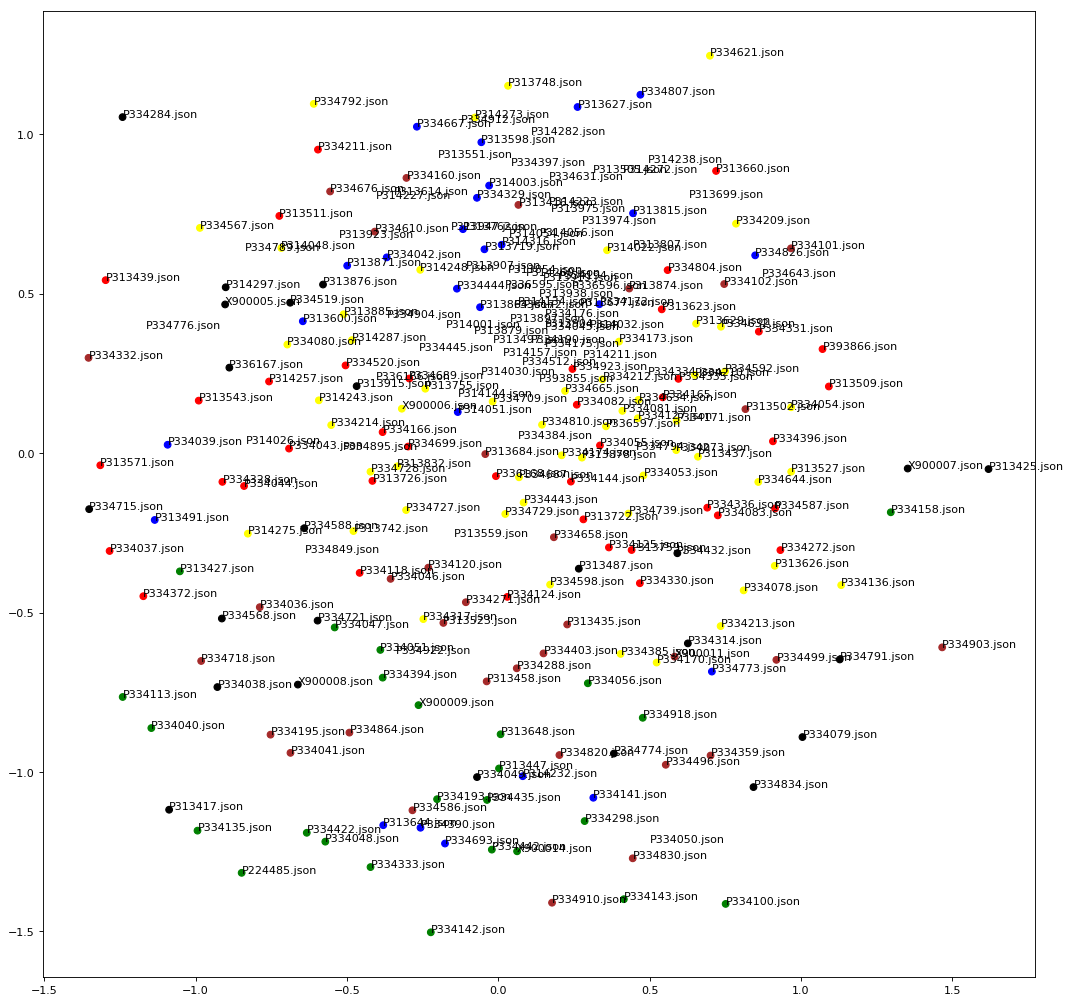

In [29]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

x_values = [xy[0] for xy in texts_2d]
y_values = [xy[1] for xy in texts_2d]
plt.scatter(x_values,y_values,c=colors_all)
for i in range(len(texts_2d)):
    plt.annotate(texts[i],(x_values[i],y_values[i]))
plt.show()